In [4]:
#Python 3.11.2
#Import packages
import scipy.integrate as scipy
import scipy.optimize as optimize
import scipy.stats as stats
import pandas as pd
import numpy as np
import pylab as pl
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import json # for pretty printing

import shutil
import sys
import os.path

In [ ]:
The data:

In [7]:
climate_data = np.array([[120., 4.835], [210., 15.405], [270., 8.315]
                         , [375., -0.73], [480.,  5.08], [570., 14.945]
                         , [630., 8.58], [735., 1.38], [840., 6.37]
                         , [930., 16.015], [990., 8.065], [1095., 0.29]
                         , [1200.,4.435], [1290., 15.885], [1350., 8.26]
                         , [1455., 0.69], [1560., 2.43], [1650., 14.77]
                         , [1710., 7.795], [1815., 0.56], [1920., 4.17]
                         , [2010., 14.325], [2070., 8.11], [2175., 0.135]
                         , [2280., 6.195], [2370., 14.495], [2430., 8.46]
                         , [2535., -4.24], [2640., 4.335], [2730., 15.35], [2790., 7.1]
                         ])

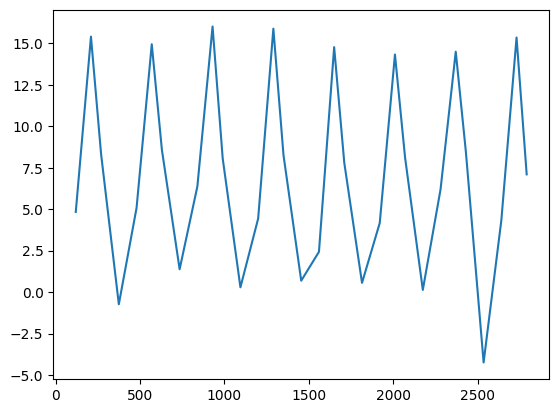

In [12]:
plt.plot(climate_data[:,0], climate_data[:,1])

Select the model

In [19]:
def residuals(parameters, climate_data):
    beta0, beta1, a = parameters
    x = climate_data[:,0] # time
    y = climate_data[:,1] # temperature
    return y - (beta0 + beta1 * np.sin(2 * np.pi * x / 365.25 - a))

Find a best fit

In [46]:
def sos(parameters, climate_data):
    return np.sum(residuals(parameters, climate_data)**2)

def best_fit(fcn, climate_data, disp=1):
    parameter_guess = np.array([0.4, 0.0, -1])
    return optimize.fmin(fcn, parameter_guess, args=(climate_data,), disp = disp)

parameter_fit = best_fit(sos, climate_data)

for name,value in zip(['beta0', 'beta1', 'a'], parameter_fit):
    print(name, " = ",  round(value,2))

Optimization terminated successfully.
         Current function value: 145.553338
         Iterations: 141
         Function evaluations: 256
beta0  =  5.89
beta1  =  -7.31
a  =  4.89


In [42]:
#Deaths by parish. Zero means we don't have information
TotalDeathsByParish = 1.0*np.array([0,40,740,0,80,60,0,0,38,70,0,0,45,0,0,0,270,45,0])
#initial day for each parish
BeginPlagueByParish = 1.0*np.array([1,61,61,91,91,91,91,121,121,121,121,121,121,121,151,181,271,331,511])
#final day for each parish. Zero means we don't have information
EndPlagueByParish = 1.0*np.array([60#Bromma
                              ,360#Oja
                              ,270#Ystad
                              ,0#Valleberga
                              ,300#Kopinge
                              ,0#Horups
					          ,0#Bjaresjo
                              ,150#Villie
                              ,510#Snarestad
                              ,270#Skarby
                              ,0#Hammenhogs
					          ,150#Glemminge
                              ,240#Balkakra
                              ,0#Baldringe
                              ,180#Ovraby
                              ,270#Sovestads
					          ,570#Loderups
                              ,570#Borrby
                              ,570#Tosterups
                              ])
print(BeginPlagueByParish[-1])
max(EndPlagueByParish)

511.0


570.0

The model. The unknown parameter is beta, which is the transmission rate.

In [32]:

#ODEs
def SIRD_model(y, t, N, beta, gamma, mu):
    S, I, R, D = y
    dS_dt = - beta * I * (S / ((S+I+R)*1.0))
    dI_dt = beta * I * (S / ((S+I+R)*1.0))  - gamma * I
    dR_dt = gamma * mu * I
    dD_dt = gamma * (1 - mu) * I
    return ([dS_dt, dI_dt, dR_dt,dD_dt])

#Parameters
gamma = 0.32
mu = 0.43
N = 299

#Initial condition
S0 = N-1
I0 = 1
R0 = 0.0
D0 = 0.0


#modelOutput : np.ndarray = scipy.odeint(SIRD_model, [S0,I0,R0,D0], t, args =(N, beta,gamma, mu))
#print(type(modelOutput))

#gato = modelOutput[-1]
#print(gato)
#print(gato[-1])



In [40]:
def sos(beta, totalDeaths):
    t = np.linspace(0, 10, 10)
    modelOutput = scipy.odeint(SIRD_model, [S0,I0,R0,D0], t, args=(N, gamma, mu, beta))
    lastOutput = modelOutput[-1]
    modelDeaths = lastOutput[-1]
    return np.sum(residuals(modelDeaths, totalDeaths)**2)

def best_fit(fcn, totalDeaths, disp=1):
    beta_guess = 0.6
    return optimize.fmin(fcn, beta_guess, args=(totalDeaths,), disp = disp)


parameter_fit = best_fit(sos, totalDeaths=60)

#for name,value in zip(['beta'], parameter_fit):
    #print(name, " = ",  round(value,2))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

In [44]:


def loss_function(beta, total_deaths):
    t = np.linspace(0, 60, 60)
    modelOutput = scipy.odeint(SIRD_model, [S0,I0,R0,D0], t, args=(N, gamma, mu, beta))
    lastOutput = modelOutput[-1]
    modelDeaths = lastOutput[-1]
    
    loss = (modelDeaths - total_deaths)**2
    return(loss)

beta = 0.5
TotalDeathsByParish = 40.0
minimum = optimize.fmin(loss_function, beta, TotalDeathsByParish)
#print(minimum)

TypeError: can only concatenate tuple (not "float") to tuple

Defining the transmission rate as a seasonality function

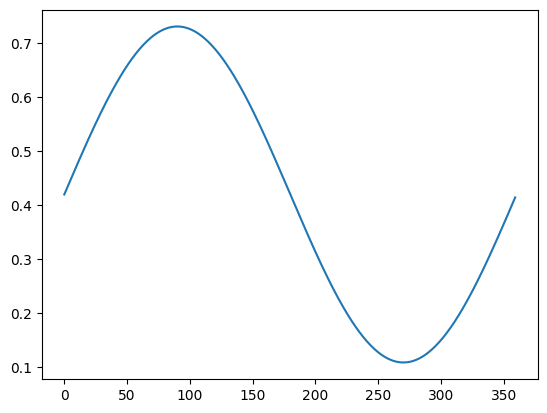

In [ ]:

def seasonal_transmission_rate(beta_0, beta_1, frequency,a, t):
    beta_t = beta_0 * (1 + beta_1 * np.sin((2 * np.pi)* frequency * t))
    return beta_t

# Generate some example data with seasonality
t = np.arange(0, 360)
beta_0 = 0.42
beta_1 = 0.74

# Plot beta 
plt.plot(t, seasonal_transmission_rate(beta_0, beta_1, 1/(360*1.0),-1.2, t))
plt.show()

